# 1. Nhập dữ liệu

In [2]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mordred import Calculator, descriptors

In [3]:
#Lấy luôn dữ liệu đã loc của tác giả
test_dataset = pd.read_csv("../data_for_modeling/HDAC3_test.csv")
train_dataset = pd.read_csv("../data_for_modeling/HDAC3_train.csv")

# 2. Xây dựng mô hình với Modred descriptors

## 2.1. Tính toán mordred descriptors

__Mã hóa cấu trúc phân tử bằng Modred descriptors__

In [4]:
#Tìm các dữ liệu (2'18s) 
# def All_Mordred_descriptors(data):
#     calc = Calculator(descriptors, ignore_3D=True)
#     mols = [Chem.MolFromSmiles(smi) for smi in data]
#     # pandas df
#     df = calc.pandas(mols)
#     return df
# train_modred_descriptors = All_Mordred_descriptors(train_dataset['SMILES'])
# test_mordred_descriptors = All_Mordred_descriptors(test_dataset['SMILES'])
# train_np = np.array(train_modred_descriptors)
# test_np = np.array(test_mordred_descriptors)
# for (row, col), value in np.ndenumerate(train_np):
#     if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
#         train_np[row, col] = 0
        
# for (row, col), value in np.ndenumerate(test_np):
#     if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
#         test_np[row, col] = 0

# train_modred_descriptors = pd.DataFrame(train_np, columns=train_modred_descriptors.columns)
# test_mordred_descriptors = pd.DataFrame(test_np, columns=test_mordred_descriptors.columns)
# test_mordred_descriptors.to_csv("../output/test_modred_des.csv", index=False)
# train_modred_descriptors.to_csv("../output/train_modred_des.csv", index=False)

In [5]:
test_mordred_descriptors = pd.read_csv("../output/test_modred_des.csv")
train_modred_descriptors = pd.read_csv("../output/train_modred_des.csv")

## 2.2 Tiền xử lý dữ liệu

## Feature selection

In [6]:
# from sklearn.preprocessing import StandardScaler
# all_mordred_descriptors = pd.concat([test_mordred_descriptors, train_modred_descriptors], ignore_index=False)
# sc = StandardScaler()
# all_modred_np = sc.fit_transform(all_mordred_descriptors)
# all_modred_data = pd.DataFrame(all_modred_np, columns=all_mordred_descriptors.columns)
# corr_matrix = all_modred_data.corr(method="pearson")

In [7]:
ic50_train = np.array(train_dataset['IC50_mean'])
for i, value in np.ndenumerate(ic50_train):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        ic50_train[i] = 0
        
train_modred_descriptors['IC50'] = ic50_train

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_modred_np = sc.fit_transform(train_modred_descriptors)
train_modred_data = pd.DataFrame(train_modred_np, columns=train_modred_descriptors.columns)
corr_matrix = train_modred_data.corr(method="pearson")

<Axes: >

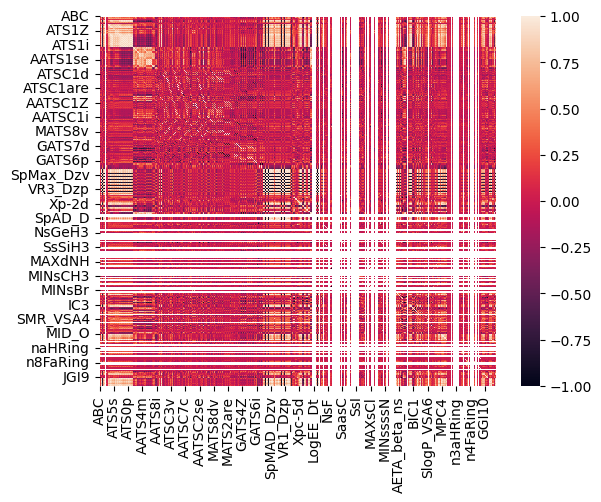

In [9]:
sns.heatmap(corr_matrix)

In [10]:
corr_matrix = corr_matrix.dropna(subset=['IC50'])
sorted_corr_matrix = corr_matrix.sort_values(by='IC50', ascending=False)

In [11]:
ic50_corrs_abs = sorted_corr_matrix['IC50'].abs()
features = sorted_corr_matrix.loc[ic50_corrs_abs > 0.05, :].index.tolist()
sorted_corr_matrix = sorted_corr_matrix.loc[features, features]
sorted_corr_matrix = sorted_corr_matrix.iloc[(-sorted_corr_matrix['IC50'].abs()).argsort()]

In [12]:
index_order = sorted_corr_matrix.index.tolist()
sorted_corr_matrix = sorted_corr_matrix[index_order].reindex(index_order)

<Axes: >

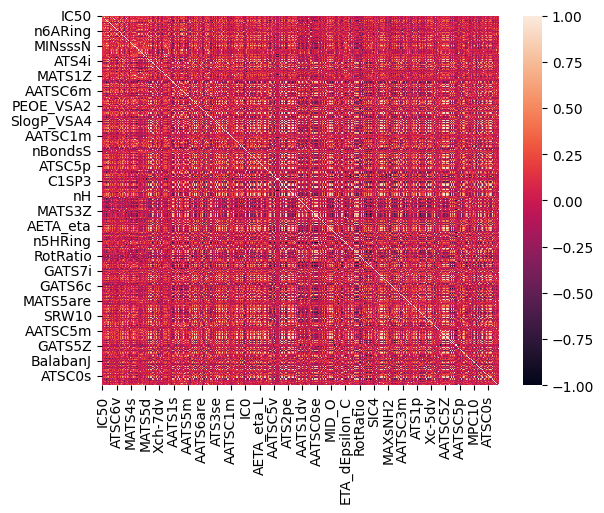

In [13]:
sns.heatmap(sorted_corr_matrix)

In [14]:
# upper_triangle = pd.DataFrame(0, index=sorted_corr_matrix.index, columns=sorted_corr_matrix.columns)
upper_triangle = sorted_corr_matrix.where(np.triu(np.ones(sorted_corr_matrix.shape)).astype(bool))

<Axes: >

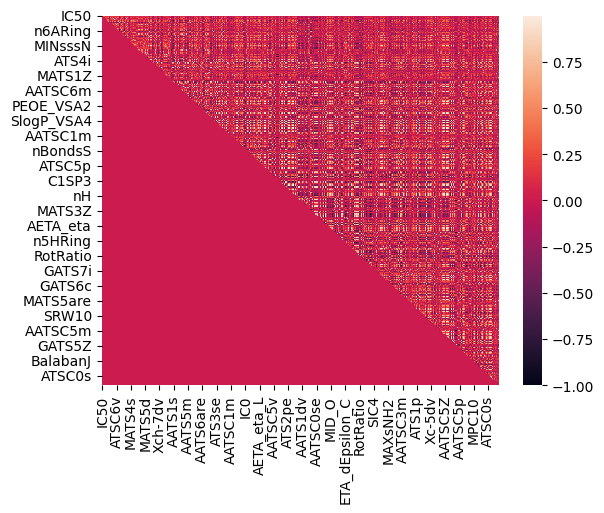

In [15]:
upper_triangle = upper_triangle.fillna(0)
upper_triangle = upper_triangle.replace(1, 0)
sns.heatmap(upper_triangle)

In [16]:
upper_triangle.to_excel("../output/HDAC3_corr_matrix_after_processing.xlsx")

In [17]:
def remove_correlated_features(sorted_df, pcc_point):
    above_095 = (sorted_df > pcc_point) | (sorted_df < -pcc_point)
    shapes = [] 
    features = []
    dropped_features = set()
    for idx, row in sorted_df.iterrows():
        if idx in dropped_features:
            continue
        print("[+] Working with row: " + idx)
        cols_rows_to_drop = []
        for col in sorted_df.columns:
            if above_095.loc[idx, col]:
                cols_rows_to_drop.append(col)
        # drop the columns
        print("[-] Detected in this row:")
        print(cols_rows_to_drop)
        for col_row_index in cols_rows_to_drop:
            dropped_features.add(col_row_index)
        #Drop the data
        sorted_df = sorted_df.drop(cols_rows_to_drop, axis=1).drop(cols_rows_to_drop, axis=0)
        shapes.append(sorted_df.shape)
        features.append(sorted_df.index.to_list())  
        # check if there are any rows left
        if len(sorted_df) == 0:
            break
    return sorted_df, shapes, features

In [18]:
matrix_before_processing = upper_triangle.iloc[1:, 1:]
result_matrix, shapes, features = remove_correlated_features(matrix_before_processing, pcc_point=0.95)

[+] Working with row: nSpiro
[-] Detected in this row:
[]
[+] Working with row: C4SP3
[-] Detected in this row:
[]
[+] Working with row: GATS8s
[-] Detected in this row:
[]
[+] Working with row: n5ARing
[-] Detected in this row:
[]
[+] Working with row: SssCH2
[-] Detected in this row:
[]
[+] Working with row: nARing
[-] Detected in this row:
[]
[+] Working with row: Xpc-5dv
[-] Detected in this row:
['Xpc-4dv', 'Xpc-6dv']
[+] Working with row: ATSC3d
[-] Detected in this row:
[]
[+] Working with row: Xc-4dv
[-] Detected in this row:
[]
[+] Working with row: ATSC5d
[-] Detected in this row:
[]
[+] Working with row: SMR_VSA4
[-] Detected in this row:
[]
[+] Working with row: GATS8se
[-] Detected in this row:
['GATS8are', 'GATS8pe']
[+] Working with row: n5AHRing
[-] Detected in this row:
[]
[+] Working with row: MDEC-24
[-] Detected in this row:
[]
[+] Working with row: ATSC6v
[-] Detected in this row:
[]
[+] Working with row: GATS2d
[-] Detected in this row:
[]
[+] Working with row: n6

In [19]:
len(result_matrix)

253

In [41]:
result_features = result_matrix.columns.to_list()
lengths = []
features_to_file = []
tmp_features = []
for features in result_features:
    tmp_features.append(features)
    lengths.append(len(tmp_features))
    features_to_file.append(tmp_features.copy())

print(features_to_file)

[['nSpiro'], ['nSpiro', 'C4SP3'], ['nSpiro', 'C4SP3', 'GATS8s'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv', 'ATSC3d'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv', 'ATSC3d', 'Xc-4dv'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv', 'ATSC3d', 'Xc-4dv', 'ATSC5d'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv', 'ATSC3d', 'Xc-4dv', 'ATSC5d', 'SMR_VSA4'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv', 'ATSC3d', 'Xc-4dv', 'ATSC5d', 'SMR_VSA4', 'MDEC-24'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv', 'ATSC3d', 'Xc-4dv', 'ATSC5d', 'SMR_VSA4', 'MDEC-24', 'ATSC6v'], ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2',

In [36]:
result_matrix['IC50'] = upper_triangle.iloc[0]
result_matrix.to_excel('../output/090_result_matrix_pcc.xlsx', index=True)

In [37]:
# create a DataFrame with the shapes and features
df_shapes = pd.DataFrame({'Len': lengths, 'Features': features_to_file})
# write the DataFrame to an Excel file
filename = '../output/090_shapes_and_features.xlsx'
df_shapes.to_excel(filename, index=False)

In [38]:
authors_features = ['IC50' ,'Xc-4dv', 'MATS4s', 'GATS1dv', 'SdssC', 'BCUTd-1h', 'GATS1s', 'GATS1are', 'AATSC3d'
                    , 'PEOE_VSA2', 'AATS4v', 'AATS4Z', 'GATS3d', 'MATS3m', 'AXp-5dv', 'EState_VSA4',
                    'ETA_eta_L', 'ATSC5m', 'RotRatio', 'SsNH2', 'ETA_epsilon_5', 'SlogP_VSA2',
                    'MID_N', 'EState_VSA5', 'Xc-5dv', 'JGI5', 'GATS5pe', 'AATSC4d']
author_features_data = corr_matrix.loc[authors_features, authors_features]
author_features_data = pd.DataFrame(author_features_data, columns=author_features_data.columns)
author_features_data.to_csv("../output/author_corr_matrix.csv")

In [ ]:
my_features = ["IC50", "nSpiro", "C4SP3", "GATS8s", "n5ARing", "SssCH2", "nARing", "Xpc-5dv", "ATSC3d", "Xc-4dv", "ATSC5d", "SMR_VSA4", "GATS8se", "n5AHRing", "MDEC-24", "ATSC6v", "GATS2d", "n6ARing", "ATSC3v", "nAHRing", "ATSC6m", "nHRing", "ATSC2d", "PEOE_VSA7", "Xc-3dv", "SMR_VSA6", "GATS4dv", "MATS4s", "MAXssCH2"]
intersection = set(my_features).intersection(set(authors_features))
print(intersection)

my_features.pop(0)
my_features_data = corr_matrix.loc[my_features, my_features]
my_features_data = pd.DataFrame(my_features_data, columns=my_features)

__Tập dữ liệu đầu vào X của tác giả__

In [49]:
X_Train_author = pd.DataFrame()
for feature in my_features:
    X_Train_author[feature] = train_modred_descriptors[feature]
X_Train_author = X_Train_author.astype(float)
X_Train_author.head()

,nSpiro,C4SP3,GATS8s,n5ARing,SssCH2,nARing,Xpc-5dv,ATSC3d,Xc-4dv,ATSC5d,...,nAHRing,ATSC6m,nHRing,ATSC2d,PEOE_VSA7,Xc-3dv,SMR_VSA6,GATS4dv,MATS4s,MAXssCH2
0,0.0,0.0,0.834635,0.0,3.495231,0.0,1.199908,-2.805293,0.0,-6.260870,...,0.0,-1112.767375,1.0,-3.659735,31.898115,0.544732,17.595212,1.049747,-0.052057,0.869909
1,0.0,0.0,0.854918,0.0,3.538553,0.0,0.697175,-4.679012,0.0,-3.629630,...,0.0,-554.397137,1.0,-5.259259,37.107112,0.350871,17.595212,1.194005,-0.112439,0.877677
2,0.0,0.0,0.852729,0.0,0.724788,0.0,1.859487,-8.739730,0.0,-1.570526,...,0.0,309.248107,1.0,-10.819592,66.088314,0.811288,6.606882,1.144448,-0.117329,0.521866
3,0.0,0.0,0.891905,0.0,2.749488,0.0,0.971216,-3.207612,0.0,-9.266436,...,0.0,-668.477848,0.0,-0.903114,37.107112,0.443468,17.595212,0.939752,-0.019351,0.729318
4,0.0,0.0,1.001975,0.0,3.858053,0.0,0.895087,2.228822,0.0,-2.931302,...,0.0,-211.632034,1.0,-0.892045,24.974377,0.355741,17.614399,1.113036,-0.080804,0.896884


In [50]:
X_Test_author_des = pd.DataFrame()
for feature in X_Train_author.columns:
    X_Test_author_des[feature] = test_mordred_descriptors[feature]
X_Test_author_des = X_Test_author_des.astype(float)
X_Test_author_des.head()

,nSpiro,C4SP3,GATS8s,n5ARing,SssCH2,nARing,Xpc-5dv,ATSC3d,Xc-4dv,ATSC5d,...,nAHRing,ATSC6m,nHRing,ATSC2d,PEOE_VSA7,Xc-3dv,SMR_VSA6,GATS4dv,MATS4s,MAXssCH2
0,0.0,0.0,0.950580,0.0,3.472656,0.0,1.356430,1.086801,0.013499,7.545779,...,0.0,175.956465,1.0,-4.492271,49.239846,0.725298,5.316789,1.007877,-0.083916,0.790896
1,0.0,0.0,0.927144,0.0,3.370892,0.0,1.550393,6.862434,0.000000,-4.295037,...,0.0,-301.341559,1.0,-1.979844,48.234015,0.743527,5.316789,0.977793,-0.076596,0.824157
2,0.0,0.0,1.162873,0.0,3.846111,0.0,1.469249,4.330579,0.000000,3.504132,...,0.0,1210.179353,1.0,-4.396694,71.830716,0.930402,5.316789,0.988425,-0.069403,0.854971
3,0.0,0.0,1.057685,0.0,1.791391,0.0,0.484429,-2.000000,0.000000,0.000000,...,0.0,-478.132157,0.0,-6.250000,31.898115,0.394338,5.316789,1.074721,-0.101899,0.616185
4,0.0,0.0,0.954750,0.0,2.769092,0.0,0.576057,-2.645628,0.000000,0.423406,...,0.0,-279.109588,0.0,-4.867193,36.958650,0.345522,5.316789,1.113990,-0.109545,0.973361


In [51]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_np = sc.fit_transform(X_Train_author)
X_test_np = sc.transform(X_Test_author_des)
X_Train_author = pd.DataFrame(X_train_np, columns = X_Train_author.columns)
X_Test_author_des = pd.DataFrame(X_test_np, columns = X_Train_author.columns)

<Axes: >

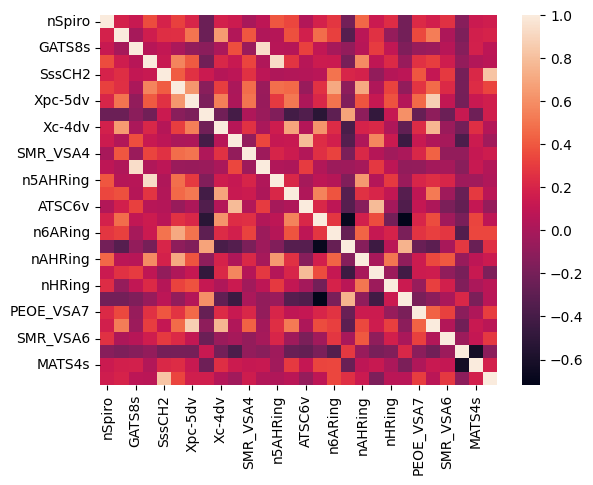

In [52]:
sns.heatmap(X_Train_author.corr())

In [53]:
X_Train_author.shape

(790, 28)

In [54]:
X_Train_author.columns

Index(['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv',
       'ATSC3d', 'Xc-4dv', 'ATSC5d', 'SMR_VSA4', 'GATS8se', 'n5AHRing',
       'MDEC-24', 'ATSC6v', 'GATS2d', 'n6ARing', 'ATSC3v', 'nAHRing', 'ATSC6m',
       'nHRing', 'ATSC2d', 'PEOE_VSA7', 'Xc-3dv', 'SMR_VSA6', 'GATS4dv',
       'MATS4s', 'MAXssCH2'],
      dtype='object')

In [55]:
y_Train_des = np.array(train_dataset['Type'])
y_Test_des = np.array(test_dataset['Type'])

## 2.3. Xây dựng mô hình

- Có 5 mô hình cần được xây dựng đó là Random Forest, K-nearest neighbors, SVM, XGBoost và Deep Neural Network. Nhưng vì chưa học đến phần Deep Learning, nên em tạm thời bỏ qua DNN.
- Các đặt tên của các mô hình sau sẽ là <tên mô hình>_<cách mã hóa>
- VD: rf_des, XGBoost_morgan2, ...

#### Random Forest Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier
rf_des_author = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_des_author.fit(X_Train_author, y_Train_des.reshape(len(y_Train_des)))

RandomForestClassifier(criterion='entropy', random_state=0)

#### K-nearest neighbors

In [76]:
from sklearn.neighbors import KNeighborsClassifier
knn_des_author = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_des_author.fit(X_Train_author, y_Train_des.reshape(len(y_Train_des)))

KNeighborsClassifier()

#### Support Vector Machine

In [77]:
from sklearn.svm import SVC
svm_des_author = SVC(kernel='rbf', probability=True, random_state=0)
svm_des_author.fit(X_Train_author, y_Train_des)

SVC(probability=True, random_state=0)

#### XGBoost

In [78]:
from xgboost import XGBClassifier
bst_des_author = XGBClassifier(n_estimators=100, objective='binary:logistic')
bst_des_author.fit(X_Train_author, y_Train_des)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# 3. Đánh giá mô hình

### 10-fold-cross validation

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [80]:
X_Total = np.concatenate((X_Train_author, X_Test_author_des), axis=0)
y_Total = np.concatenate((y_Train_des, y_Test_des), axis=0)

In [81]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(knn_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.833))

scores = cross_val_score(svm_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.847))

scores = cross_val_score(rf_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.857))

scores = cross_val_score(bst_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.822))

Độ chính xác của 10-fold cross validation: 0.814 (0.043)
So sánh với độ chính xác của bài báo là: 0.833
Độ chính xác của 10-fold cross validation: 0.799 (0.048)
So sánh với độ chính xác của bài báo là: 0.847
Độ chính xác của 10-fold cross validation: 0.810 (0.034)
So sánh với độ chính xác của bài báo là: 0.857
Độ chính xác của 10-fold cross validation: 0.808 (0.034)
So sánh với độ chính xác của bài báo là: 0.822


### Accuracy, Sensitivity, Specificity

In [82]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

In [83]:
def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    se = tp/(tp+fn)
    sp = tn/(tn+fp)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return ac, se, sp, mcc

In [84]:
def me_result(cm, ac1, se1, sp1, mcc1):
    print("Confusion matrix:")
    print(cm)
    ac, se, sp, mcc = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [[' ' 'AC', 'SE', 'SP', 'MCC'], ['Shin Liu et at', ac1, se1, sp1, mcc1], ['My model', ac, se, sp, mcc]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

KNN

In [85]:
#KNN
y_knn_pred = knn_des_author.predict(X_Test_author_des)
cm = confusion_matrix(y_Test_des, y_knn_pred)
ac1, se1, sp1, mcc1 = 0.859, 0.950, 0.644, 0.648
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 37  22]
 [  9 130]]
Comparision:
╒════════════════╤══════════╤══════════╤══════════╤══════════╕
│                │       AC │       SE │       SP │      MCC │
╞════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.859    │ 0.95     │ 0.644    │ 0.648    │
├────────────────┼──────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.843434 │ 0.804348 │ 0.855263 │ 0.609053 │
╘════════════════╧══════════╧══════════╧══════════╧══════════╛


RF

In [87]:
#RF
y_rf_pred = rf_des_author.predict(X_Test_author_des)
cm = confusion_matrix(y_Test_des, y_rf_pred)
ac1, se1, sp1, mcc1 = 0.798 ,0.827 ,0.729 ,0.538
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 35  24]
 [  6 133]]
Comparision:
╒════════════════╤══════════╤══════════╤══════════╤══════════╕
│                │       AC │       SE │       SP │      MCC │
╞════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.798    │ 0.827    │ 0.729    │ 0.538    │
├────────────────┼──────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.848485 │ 0.853659 │ 0.847134 │ 0.620866 │
╘════════════════╧══════════╧══════════╧══════════╧══════════╛


SVM

In [86]:
#SVM
y_svm_pred = svm_des_author.predict(X_Test_author_des)
cm = confusion_matrix(y_Test_des, y_svm_pred)
ac1, se1, sp1, mcc1 = 0.859 ,0.950 ,0.644 ,0.648
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 26  33]
 [  8 131]]
Comparision:
╒════════════════╤══════════╤══════════╤═════════╤══════════╕
│                │       AC │       SE │      SP │      MCC │
╞════════════════╪══════════╪══════════╪═════════╪══════════╡
│ Shin Liu et at │ 0.859    │ 0.95     │ 0.644   │ 0.648    │
├────────────────┼──────────┼──────────┼─────────┼──────────┤
│ My model       │ 0.792929 │ 0.764706 │ 0.79878 │ 0.464634 │
╘════════════════╧══════════╧══════════╧═════════╧══════════╛


XGboost

In [88]:
y_bst_pred = bst_des_author.predict(X_Test_author_des)
cm = confusion_matrix(y_Test_des, y_bst_pred)
ac1, se1, sp1, mcc1 = 0.773 ,0.770 ,0.780 ,0.514
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 34  25]
 [ 12 127]]
Comparision:
╒════════════════╤══════════╤═════════╤══════════╤═════════╕
│                │       AC │      SE │       SP │     MCC │
╞════════════════╪══════════╪═════════╪══════════╪═════════╡
│ Shin Liu et at │ 0.773    │ 0.77    │ 0.78     │ 0.514   │
├────────────────┼──────────┼─────────┼──────────┼─────────┤
│ My model       │ 0.813131 │ 0.73913 │ 0.835526 │ 0.53061 │
╘════════════════╧══════════╧═════════╧══════════╧═════════╛


### AUC

In [89]:
from sklearn.metrics import roc_auc_score
knn_y_proba = knn_des_author.predict_proba(X_Test_author_des)[:, 1]
rf_y_proba = rf_des_author.predict_proba(X_Test_author_des)[:, 1]
svm_y_proba = svm_des_author.predict_proba(X_Test_author_des)[:, 1]
bst_y_proba = bst_des_author.predict_proba(X_Test_author_des)[:, 1]


knn_auc_score = roc_auc_score(y_Test_des, knn_y_proba)
rf_auc_score = roc_auc_score(y_Test_des, rf_y_proba)
svm_auc_score = roc_auc_score(y_Test_des, svm_y_proba)
bst_auc_score = roc_auc_score(y_Test_des, bst_y_proba)
print(knn_auc_score, rf_auc_score, svm_auc_score, bst_auc_score)

0.885014022680161 0.9220217046701622 0.8292891110840142 0.8666016339470797


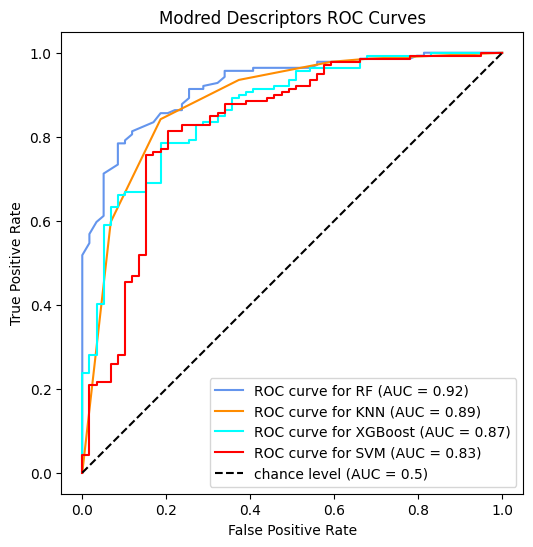

In [90]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=rf_des_author, 
    X=X_Test_author_des, 
    y=y_Test_des,
    name=f"ROC curve for RF",
    color='cornflowerblue',
    ax=ax)


RocCurveDisplay.from_estimator(
    estimator=knn_des_author, 
    X=X_Test_author_des, 
    y=y_Test_des,
    name=f"ROC curve for KNN",
    color='darkorange',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=bst_des_author, 
    X=X_Test_author_des, 
    y=y_Test_des,
    name=f"ROC curve for XGBoost",
    color='aqua',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_des_author, 
    X=X_Test_author_des, 
    y=y_Test_des,
    name=f"ROC curve for SVM",
    color='red',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Modred Descriptors ROC Curves")
plt.legend()
plt.show()